# Simulation script for RF manipulation

## Introduction

<img src="./input_files/LHC25%2348b_BCMS_PS_TFB_2018/RF.png" alt="rf program" width="600"/>

This is the complete acceleration cycle in the PS for beams sent to the LHC for collisions. The RF program is shown in colors. We will focus first on the last RF manipulation consisting in splitting bunches in two, twice. We go from the rf harmonic $h=21$ (C10) to $h=42$, (C20) then $h=84$ (C40). This corresponds to the time in the cycle between $2.710$ s and $2.843$ s.

<img src="./input_files/LHC25%2348b_BCMS_PS_TFB_2018/foursplitb6_datamatrix.png" alt="foursplit" width="600"/>

This is the evolution of the bunch profile in the longitudinal direction (x-axis, expressed in time), during the manipulation (y-axis, expressed in number of machine turns). Each line in the plot corresponds to a measured profile in the Wall Current Monitor. Both splittings can be seen, an error in phase between the rf systems at each step will result in a non-uniform distribution of the particles in the end. note that we have $12$ to $18$ bunches at the start (in $h=21$), yielding $48$ to $72$ bunches after the manipulation. Only one bunch is shown here, all should be identical if the prior manipulations are done correctly...

<img src="./input_files/LHC25%2348b_BCMS_PS_TFB_2018/foursplitb6_firstprofile.png" alt="foursplit" width="600"/>

This is the very first profile measured, before the splittings. The bunch is close to a parabola with the relationship

$
\lambda = \lambda_0\left[1-4\left(\frac{\tau}{\tau_l}\right)\right]^{\mu+1/2}
$

## Imports

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
import time
import datetime

In [2]:
# BLonD imports
from blond.input_parameters.ring import Ring, RingOptions
from blond.input_parameters.rf_parameters import RFStation
from blond.beam.beam import Proton, Beam
from blond.beam.profile import Profile, CutOptions
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
# from blond.impedances.impedance_sources import Resonators, InputTable
# from blond.impedances.impedance import InducedVoltageFreq, InductiveImpedance, TotalInducedVoltage
from blond.beam.distributions_multibunch import match_beam_from_distribution

## Simulation inputs

In [3]:
# Simulation parameters
plot_turn = 5000
time_sim_start = 2710e-3
time_sim_end = 2843e-3

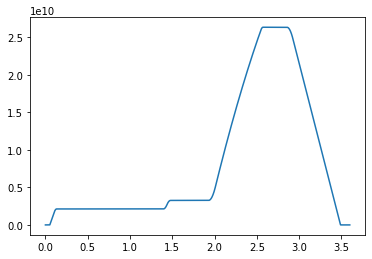

In [4]:
# General parameters
circumference = 2.*np.pi*100.                    # Machine circumference [m]
gamma_transition = 6.1                           # Transition gamma
momentum_compaction = 1./gamma_transition**2  # Momentum compaction array
particle_type = Proton()
ramp_interpolation = 'linear'
loaded_momentum = np.load('./input_files/LHC25#48b_BCMS_PS_TFB_2018/ramp.npz')
time_momentum = loaded_momentum['time']*1e-3        # Time [s] 
momentum = loaded_momentum['momentum']*1e9          # Momentum [eV/c]

plt.plot(time_momentum, momentum)

In [5]:
# RF parameters 
n_rf_systems = 2                                         # Number of rf systems 
harmonic_numbers = [21, 42]#, 84]                          # Harmonic numbers
loaded_h21 = np.load('./input_files/LHC25#48b_BCMS_PS_TFB_2018/C10_h-21.npz')
time_h21 = loaded_h21['time']*1e-3                          # Time [s]
voltage_h21 = loaded_h21['amplitude']*1e3                   # Voltage [V]
loaded_h42 = np.load('./input_files/LHC25#48b_BCMS_PS_TFB_2018/C20.npz')
time_h42 = loaded_h42['time']*1e-3                          # Time [s]
voltage_h42 = loaded_h42['amplitude']*1e3                   # Voltage [V]
#loaded_h84 = np.load('./input_files/LHC25#48b_BCMS_PS_TFB_2018/C40.npz')
#time_h84 = loaded_h84['time']*1e-3                          # Time [s]
#voltage_h84 = loaded_h84['amplitude']*1e3                   # Voltage [V]

20000.61


(0.0, 22000.671000000002)

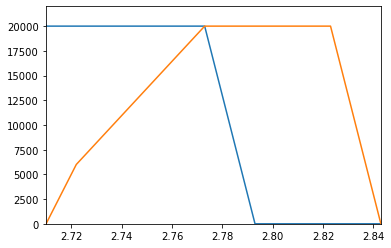

In [6]:
plt.plot(time_h21, voltage_h21)
plt.plot(time_h42, voltage_h42)
#plt.plot(time_h84, voltage_h84)
plt.xlim((time_sim_start,time_sim_end))
print(voltage_h42[time_h42<=time_sim_end][-2])
plt.ylim((0, 1.1*voltage_h42[time_h42<=time_sim_end][-2]))

In [7]:
# Phase offsets, the possible errors
dpc20 = 0
dpc40 = 0
phi_offsets =  [0, dpc20/180*np.pi]#, dpc40/180*np.pi]     # For 2x2 splitting

In [8]:
# Beam parameters
n_bunches = 4

initial_bunch_length_full = 52e-9
initial_exponent = 1.

n_macroparticles_per_bunch = int(1e4)
intensity_per_bunch = 1.3e11

intensity = intensity_per_bunch*n_bunches*4
n_macroparticles = int(n_macroparticles_per_bunch*n_bunches*4)

In [9]:
# Profile parameters
n_slices_per_bunch = 2**4
bunch_spacing_buckets = 1
n_slices = int(n_slices_per_bunch*(bunch_spacing_buckets*(harmonic_numbers[0]-1)+1))
cut_left = 0.
cut_right = 2*np.pi*(bunch_spacing_buckets*(harmonic_numbers[0]-1)+1)

## Building BLonD objects

In [10]:
### Ring object

momentum = momentum[(time_momentum>=time_sim_start)*(time_momentum<=time_sim_end)]
time_momentum = time_momentum[(time_momentum>=time_sim_start)*(time_momentum<=time_sim_end)]

ring_options = RingOptions(interpolation=ramp_interpolation,
                              t_start=time_sim_start,
                              t_end=time_sim_end)
ring = Ring(circumference, momentum_compaction,
            (time_momentum, momentum), particle_type,
            RingOptions=ring_options)

/eos/home-j/jwulff/SWAN_projects/JWulff_RFManipulation_Optimization_Real/blond/input_parameters/ring.py:232: UserWarning: WARNING in Ring: The number of turns for the simulation was changed by passing a momentum program.
  warnings.warn("WARNING in Ring: The number of turns for the " +


63418
0.9993674272714262
28.118908684457484
26383187168.160072
0.02687449610319807
26383187168.160072


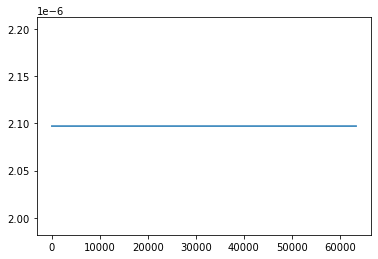

In [11]:
print(ring.n_turns)
print(ring.beta[0,0])
print(ring.gamma[0,0])
print(ring.energy[0,0])
print(ring.alpha_0[0,0])
print(ring.energy[0,0])
plt.plot(ring.t_rev[:])

In [13]:
### RFStation object

voltage_h21 = voltage_h21[(time_h21>=time_sim_start)*(time_h21<=time_sim_end)]
time_h21 = time_h21[(time_h21>=time_sim_start)*(time_h21<=time_sim_end)]

voltage_h42 = voltage_h42[(time_h42>=time_sim_start)*(time_h42<=time_sim_end)]
time_h42 = time_h42[(time_h42>=time_sim_start)*(time_h42<=time_sim_end)]

#voltage_h84 = voltage_h84[(time_h84>=time_sim_start)*(time_h84<=time_sim_end)]
#time_h84 = time_h84[(time_h84>=time_sim_start)*(time_h84<=time_sim_end)]

rf_station = RFStation(ring, harmonic_numbers,
                       ((time_h21, voltage_h21),
                        (time_h42, voltage_h42)),
                       phi_offsets,
                       n_rf=n_rf_systems)

/eos/home-j/jwulff/SWAN_projects/JWulff_RFManipulation_Optimization_Real/blond/input_parameters/rf_parameters.py:449: RuntimeWarning: invalid value encountered in true_divide
  acceleration_ratio = denergy/(Particle.charge*RFStation.voltage[0, :])
/eos/home-j/jwulff/SWAN_projects/JWulff_RFManipulation_Optimization_Real/blond/input_parameters/rf_parameters.py:450: RuntimeWarning: invalid value encountered in greater
  acceleration_test = np.where((acceleration_ratio > -1) *
/eos/home-j/jwulff/SWAN_projects/JWulff_RFManipulation_Optimization_Real/blond/input_parameters/rf_parameters.py:451: RuntimeWarning: invalid value encountered in less
  (acceleration_ratio < 1) is False)[0]
/eos/home-j/jwulff/SWAN_projects/JWulff_RFManipulation_Optimization_Real/blond/input_parameters/rf_parameters.py:468: RuntimeWarning: invalid value encountered in remainder
  phi_s[index] = (np.heaviside(np.sign(Particle.charge),0) * np.pi - phi_s[index]) % (2*np.pi)


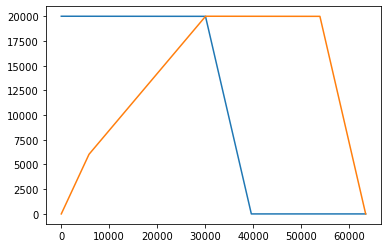

In [14]:
plt.plot(rf_station.voltage[0,:])
plt.plot(rf_station.voltage[1,:])
#plt.plot(rf_station.voltage[2,:])

In [15]:
### Beam
beam = Beam(ring, n_macroparticles, intensity)


### Profile
cut_options = CutOptions(cut_left, cut_right, n_slices=n_slices,
                         cuts_unit='rad', RFSectionParameters=rf_station)
profile = Profile(beam, CutOptions=cut_options)

In [16]:
### Tracker

longitudinal_tracker = RingAndRFTracker(rf_station, beam)

full_tracker = FullRingAndRF([longitudinal_tracker])


### Beam generation
distribution_options = {'type': 'binomial', 'exponent': initial_exponent,
                        'bunch_length': initial_bunch_length_full,
                        'bunch_length_fit': 'full', 
                        'density_variable': 'Hamiltonian'}

match_beam_from_distribution(beam, full_tracker, ring,
                             distribution_options, n_bunches,
                             bunch_spacing_buckets,
                             n_points_potential=int(1e3))

4 stationary bunches without intensity generated


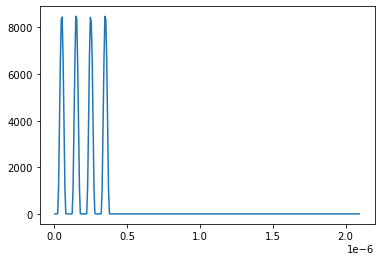

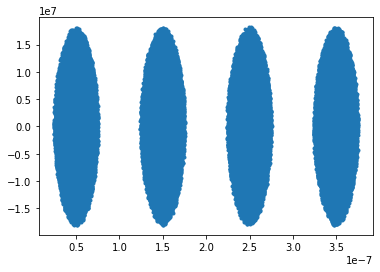

In [17]:
profile.track()
plt.plot(profile.bin_centers, profile.n_macroparticles)
profile.rms_multibunch

plt.figure()
plt.plot(beam.dt, beam.dE, '.')

## Tracking

In [18]:
# Move the bunches in the center of the turn
beam.dt += rf_station.t_rf[0,0]

datamatrix = np.zeros((int(ring.n_turns/100), len(profile.n_macroparticles)))

for turn in range(ring.n_turns):

    if(turn%plot_turn==0):
        t0 = time.perf_counter()
        
    if (turn%100==0):
        datamatrix[int(turn/100), :] = profile.n_macroparticles

    # Track
    full_tracker.track()
    profile.track()
    

    if(turn%plot_turn==0):
        t1 = time.perf_counter()
        print('Turn %d over %d, ETC: %s' %(
            turn, ring.n_turns, datetime.timedelta(seconds=(t1-t0)*(ring.n_turns-turn))))

Turn 0 over 63418, ETC: 0:09:30.670487
Turn 5000 over 63418, ETC: 0:03:33.354919
Turn 10000 over 63418, ETC: 0:03:13.071990
Turn 15000 over 63418, ETC: 0:02:55.191383
Turn 20000 over 63418, ETC: 0:02:36.758995
Turn 25000 over 63418, ETC: 0:02:23.401102
Turn 30000 over 63418, ETC: 0:02:00.703176
Turn 35000 over 63418, ETC: 0:01:43.145802
Turn 40000 over 63418, ETC: 0:01:24.689815
Turn 45000 over 63418, ETC: 0:01:06.480508
Turn 50000 over 63418, ETC: 0:00:48.893810
Turn 55000 over 63418, ETC: 0:00:30.363793
Turn 60000 over 63418, ETC: 0:00:12.375098


IndexError: index 634 is out of bounds for axis 0 with size 634

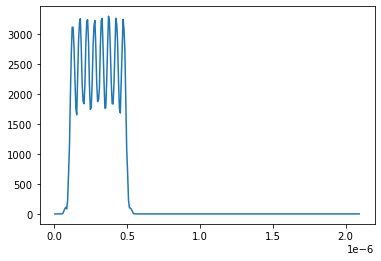

In [19]:
plt.plot(profile.bin_centers, profile.n_macroparticles)
#plt.xlim((rf_station.t_rf[0,0], rf_station.t_rf[0,0]+rf_station.t_rf[0,0]))

(0.0, 100.0)

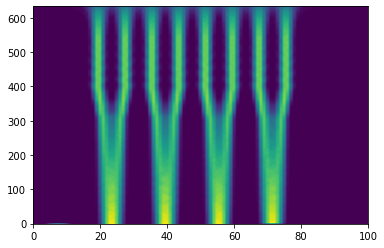

In [21]:
plt.imshow(datamatrix, aspect='auto', origin='lower')
plt.xlim((0, 100))